# Installing Dependencies

In [ ]:
%pip install tensorflow opencv-python matplotlib

# Importing Deopendencies

In [1]:
# Importing Standard Dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten # type: ignore
import tensorflow as tf

If GPU Use This to Prevent Tensorflow from overweighting your GPU

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "Type:", gpu.device_type)
    tf.config.experimental.set_memory_growth(gpu, True)

# Creating Directories Structure

In [5]:
# Setting Folder Structure
# Paths
# POS_PATH = os.path.join('data', 'positive')
# NEG_PATH = os.path.join('data', 'negative')
# ANC_PATH = os.path.join('data', 'anchor')

POS_PATH = os.path.join('augmented_data', 'positive')
NEG_PATH = os.path.join('augmented_data', 'negative')
ANC_PATH = os.path.join('augmented_data', 'anchor')



In [ ]:

# Make Them
try:
    os.makedirs(POS_PATH)
    os.makedirs(NEG_PATH)
    os.makedirs(ANC_PATH)
except Exception as ae:
    print(f"Exception: {ae}")

# Downloading Dataset

In [24]:
# Labeled Faces in the Wild Dataset
# http://vis-www.cs.umass.edu/lfw/#download 
!tar -xf lfw.tgz 

Getting Data to our Folder Structure (Labels isn't Needed)

In [ ]:
# Move LFW Images to the following dir data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH) # no need to get the names of people

# Creating Positive and Anchor Images

In [1]:
# Import uuid library to generate unique image names
import uuid # Universally unique identifiers
uuid.uuid1()

UUID('19c223da-c140-11ef-b1f0-105badc81c10')

In [3]:
import cv2
import os
# Establish a connection to the webcam
x = 127
y = 200
NEWANC_PATH = os.path.join('val')
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down the frame to 250x250px (to match the resolution of our Training Images)
    frame = frame[x:x+250, y:y+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(NEWANC_PATH, f'{uuid.uuid1()}.jpg')

        # Write Anchor Image
        cv2.imwrite(imgname, frame)
        

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')

        # Write Anchor Image
        cv2.imwrite(imgname, frame)
        

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
# x and y of the top left point in the cropped frame
x = 120
y = 200
plt.imshow(frame[x:x+250, y:y+250, :])

# Load and Preprocess Images

## Load

In [11]:
# Grab all images within the directories and Creating a Dataset to allow us to loop on all images
# You Can Change the number of the images taken (300) according to the model preformance!!!!!!!!!!!!!!!!!!!!!!!!!!!!
anchor  = tf.data.Dataset.list_files(ANC_PATH + '\\*.jpg').take(900)
positive  = tf.data.Dataset.list_files(POS_PATH + '\\*.jpg').take(900)
negative  = tf.data.Dataset.list_files(NEG_PATH + '\\*.jpg').take(900)



## Preprocess

In [6]:
# Write a Preproccessing funtion thats gonna:
# 1- Load the image
# 2- Resize it
# 3- Scailing from (0 --> 255) to  (0 --> 1)    This helps a neural network optimize a lot easier in gradient decent

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path) # Loads the file
    img = tf.io.decode_jpeg(byte_img)     # Decodes it in order to deal only with image pixel values
    img = tf.image.resize(img, (105,105)) # Resizing it: to the size mentioned in the Siamese paper
    img = img / 255.0                     # Preforming the Scaling (0 --> 1)
    return img

## Creating our Labeled Dataset

In [13]:
# We wall pass to our model the data in this way of sending batches
# (anchor, positive) ==> 1,1,1,1,1
# (anchor, negative) ==> 0,0,0,0,0

# tf.ones_like([-3, 0.4, 1, 3, 6]) ==> 1,1,1,1,1 if all nums returns an array of ones with the same length

# zipping allows grouping them to iterate on all of them
# tf.data.Dataset.from_tensor_slices converts the created array from tf.ones/zeros to the format of the itreator like anchor and positi.....
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data      = positives.concatenate(negatives)

In [14]:
# Then we are gonna use our tensorflow dataset map method (dataset.map(preprocess_twin)) to apply it on all of the images
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [15]:
# Build dataloader pipleline
data = data.map(preprocess_twin)
data = data.cache() 
data = data.shuffle(buffer_size=1024)

In [16]:
data_samples = data.as_numpy_iterator()

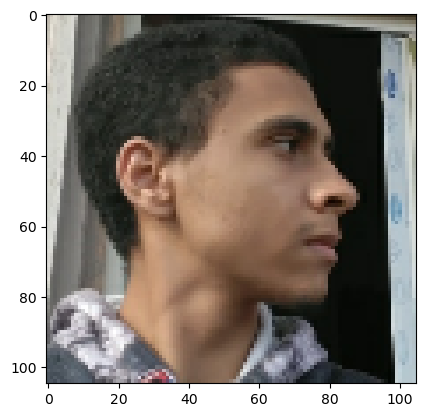

In [17]:
samp = data_samples.next()
plt.imshow(samp[0])

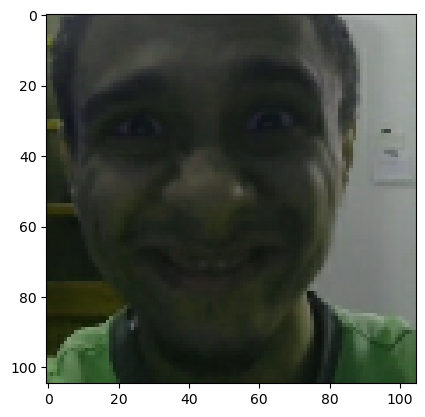

In [18]:
plt.imshow(samp[1])

In [19]:
samp[2]

1.0

Dataset Done

In [20]:
# Training Partition
train_data = data.take(round(len(data)*0.7)) # taking 70% of the data as training
# We are going to pass our data to the model as batches of 16 samples
train_data = train_data.batch(16)
# Starts Preprocess the next batch while the current elements are being processed and 8 is the number of batches that will be processed = 8
# in this case 8 batches of 16 samples each
train_data = train_data.prefetch(8)

In [21]:
# Tetsting partition
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Building the Neural Network

## build the embedding layer

In [21]:
def make_embedding():
    inp = Input(shape=(105,105,3), name='input_image')

    # First Block
    c1  = Conv2D(64, (10,10), activation='relu')(inp)
    m1  = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second Block
    c2  = Conv2D(128, (7,7), activation='relu')(m1)
    m2  = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third Block
    c3  = Conv2D(128, (4,4), activation='relu')(m2)
    m3  = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final Block
    c4  = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1) # Fully Connected Layer


    return Model(inputs= [inp], outputs = [d1], name = 'embedding')

In [22]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Creating Custom Layer
# L1 Distance Class
class L1Dist(Layer):

    # Init method - Inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
    # This is were the majic happens
    # We Subtract the two embeddings from each others
    # My Guess= if the result is really close to an array of zeros then its verified else its not

    # Similarity Calculation
    def call(self, input_embedding, validation_embedding):
        # Ensure inputs are tensors (They have to be tenosrs not lists)
        input_embedding = tf.convert_to_tensor(input_embedding)       
        validation_embedding = tf.convert_to_tensor(validation_embedding)

        return tf.math.abs(input_embedding - validation_embedding)

### Bring it all together

In [24]:
def make_siamese_model():

    # Handle inputs
    # Anchor image
    input_image = Input(name='input_image', shape=(105,105,3))
    input_embedding = embedding(input_image)

    # Validation image
    validation_image = Input(name='validation_image', shape=(105,105,3))
    validation_embedding = embedding(validation_image)

    # Passing both of the images to the combined model
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(input_embedding, validation_embedding)
    
    # Classification Layer
    classifier = Dense(1, activation="sigmoid")(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [25]:
# SiameseModel = make_siamese_model()
# SiameseModel.summary()

SiameseModel = tf.keras.models.load_model('siamesemodel_60.h5',
                                     custom_objects={'L1Dist':L1Dist, 'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

# Setting Up Losses and Optimizers

In [26]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)


# Defining Our Custom Training Step

In [10]:
@tf.function
def train_step(batch):
    # Record all of our operations
    with tf.GradientTape() as tape: # Allows us to get our gradients
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward Propagation
        yhat = SiameseModel({"input_image": X[0], "validation_image": X[1]}, training=True) # VERY IMPORTANT to set training = True because some layers won't activate unless its set to True
        yhat = tf.reshape(yhat, tf.shape(y))
        # Calculate Loss
        loss = binary_cross_entropy(y, yhat)

    # Calculate Gradients
    grad = tape.gradient(loss, SiameseModel.trainable_variables)

    # Calculate updated weights and apply to Siamese Model
    opt.apply_gradients(zip(grad, SiameseModel.trainable_variables))
    return loss

# Building our Training Loop

In [8]:
def train(data, EPOCHS):
    best_val_loss = float('inf') # Initialize to Infinity
    patience = 5                 # Number of epochs to wait for improvements
    wait = 0                     # Counter for epochs
    total_loss = 0 
    # Loop thourgh epochs
    for epoch in range(1, EPOCHS+1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data), stateful_metrics=['loss']) # If you wrapped this up in the Model Class you would get the progress bar without you manually doing it

        # Loop through each batch
        for idx, batch in enumerate(data): # enumarte gives us a counter and the actual batch
            # Run train step here
            loss = train_step(batch)
            progbar.update(idx+1, values=[('loss', float(loss))])
            total_loss += float(loss)
        
        # Vaidation Step
        total_loss /= len(data) # No. of batches in the training data
        is_improvement = total_loss < best_val_loss
        if is_improvement:
            best_val_loss = total_loss
            wait = 0 # Reset the counter because the model is improving!
        else:
            wait += 1
            if wait >= patience:
                print("Wait Exceeded Patience!!")
                print(f"Early Stopping at Epoch {epoch}")
                break
        
        # Print epoch summary
        print(f'Epoch {epoch} - '
          f'Loss: {total_loss:.4f} '
          f'({"Improved" if is_improvement else "Not Improved"})')


        # Save Checkpoints
        if epoch % 10 == 0: # Every 10 Epochs
            SiameseModel.save(f'{epoch}.h5') # IMPORTANT it doesn't save models architechture so its not enough 
            # model.save() saves every thing [saves optimizer state as well]



# Train The Model

In [11]:
EPOCHS = 30
train(train_data, EPOCHS)

NameError: name 'train_data' is not defined

# Evaluate the Model

In [9]:
# Import metric Calculations
from tensorflow.keras.metrics import Precision, Recall
SiameseModel = tf.keras.models.load_model('siamesemodel_finetuned_20.h5',
                                     custom_objects={'L1Dist':L1Dist, 'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

In [36]:

# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [37]:
# Make Predictions
y_hat = smodel.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[[9.9971676e-01],
        [9.2693313e-05],
        [8.1342427e-05],
        [1.9818890e-06],
        [9.9999875e-01],
        [9.9999946e-01],
        [5.5108039e-08],
        [3.3589365e-06],
        [9.9945939e-01],
        [1.9827299e-08],
        [1.3383205e-05],
        [9.1582161e-01],
        [1.0748053e-03],
        [9.9999356e-01],
        [1.4914838e-02],
        [9.9997926e-01]]], dtype=float32)

In [38]:
# Proccessing the results
threshold = 0.85
y_hat_thresholded = np.array([1.0 if prediction[0] > threshold else 0.0 for prediction in y_hat[0]], dtype='float32')
y_hat_thresholded

array([1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

In [39]:
y_true

array([1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

In [46]:
# Creating a metric object
m = Recall()

# Calculating the Recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

# Visualize the results

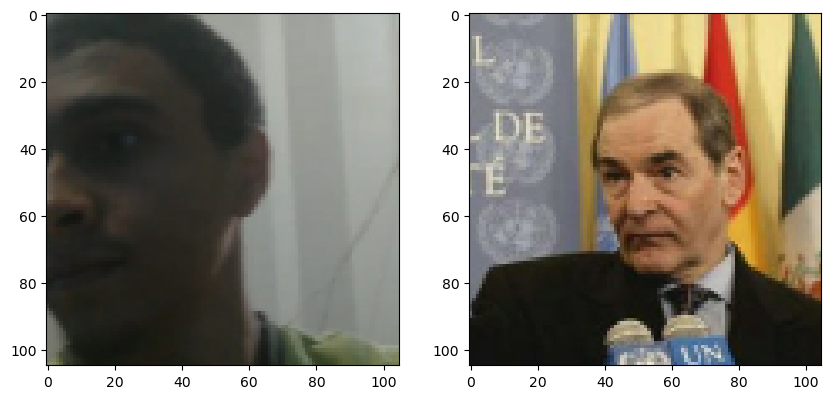

In [ ]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first Subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

# Reload the Model

In [1]:
smodel = tf.keras.models.load_model('siamesemodel_60.h5',
                                     custom_objects={'L1Dist':L1Dist, 'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

NameError: name 'tf' is not defined

In [51]:
SiameseModel.save('siamesemodel_60.h5')

# Real-time Deploying

In [6]:
# Verification Funciton
def verify(model, detection_threshold, verification_threshold):
    # Build results
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)
    
    # Detection threshold: the Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold) # SEE HERE
    # np.array(results) > detection_threshold returns an array of True/False Elements both in calculations act as 1/0

    # Verification threshold: the Proportion of positive predictions over total positive samples (50)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [10]:
# Open CV realtime Verification

cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250]

    # OR To Intelligently crop the face in any place you can use MTCNN
    # For preformance issues I'm not using it : (

    # from mtcnn import MTCNN
    # # Initialize MTCNN detector
    # detector = MTCNN()
    # # Convert frame to RGB for MTCNN
    # frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # # Detect faces
    # detections = detector.detect_faces(frame_rgb)

    # # Draw bounding boxes on the original frame
    # for detection in detections:
        # x, y, width, height = detection['box']
        # x, y = max(0, x), max(0, y)
        # cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)
    # cv2.imshow('Verification', frame)

    # # If 'v' is pressed
    # if cv2.waitKey(10) & 0xFF == ord('v'):
        # for detection in detections:
            # # Get bounding box
            # x, y, width, height = detection['box']
            # x, y = max(0, x), max(0, y)
            
            # # Crop and resize the face
            # cropped_face = frame_rgb[y:y + height, x:x + width]
            # resized_face = cv2.resize(cropped_face, (250, 250))
            
            # # Display the cropped face in a new window
            # cv2.imshow('Cropped Face', cv2.cvtColor(resized_face, cv2.COLOR_RGB2BGR))
            
            # # Wait until any key is pressed to close the cropped face window
            # cv2.waitKey(0)
            # cv2.destroyWindow('Cropped Face')
       
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to input application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)

        # Verification
        results, verified = verify(smodel, 0.98, 0.9)
        print(verified)

    cv2.imshow('Verification', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

TypeError: 'NoneType' object is not subscriptable

In [11]:

cap.release()
cv2.destroyAllWindows()

In [52]:
results

[array([[[1.]]], dtype=float32),
 array([[[1.]]], dtype=float32),
 array([[[1.]]], dtype=float32),
 array([[[1.]]], dtype=float32),
 array([[[0.999213]]], dtype=float32),
 array([[[0.2804153]]], dtype=float32),
 array([[[0.6548]]], dtype=float32),
 array([[[0.906753]]], dtype=float32),
 array([[[0.9696752]]], dtype=float32),
 array([[[0.9486021]]], dtype=float32),
 array([[[0.56292605]]], dtype=float32),
 array([[[0.9999644]]], dtype=float32),
 array([[[0.99997157]]], dtype=float32),
 array([[[0.9999597]]], dtype=float32),
 array([[[0.999878]]], dtype=float32),
 array([[[0.9998432]]], dtype=float32),
 array([[[0.999947]]], dtype=float32),
 array([[[0.02805195]]], dtype=float32),
 array([[[0.999709]]], dtype=float32),
 array([[[0.9995858]]], dtype=float32),
 array([[[0.99916977]]], dtype=float32),
 array([[[0.99965304]]], dtype=float32),
 array([[[0.99943477]]], dtype=float32),
 array([[[0.9997636]]], dtype=float32),
 array([[[0.99924636]]], dtype=float32),
 array([[[0.9992498]]], dtype

In [22]:
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
total_best_detection_threshold = 0
total_best_verification_threshold = 0
for idx, batch in enumerate(test_data):
    # Get a batch of test data
    test_input, test_val, y_true = batch[0], batch[1], batch[2]
    y_scores_pre = smodel.predict([test_input, test_val])
    y_scores = np.array([prediction for prediction in y_scores_pre[0]], dtype='float32')


    # Detection Threshold (T_d)
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Avoid div by zero
    best_detection_threshold = thresholds[np.argmax(f1_scores)]

    # Verification Threshold (T_v)
    verification_ratios = precision * recall  # Adjust based on your definition
    best_verification_threshold = verification_ratios[np.argmax(f1_scores)]

    print(f"Optimal Detection Threshold {idx}:", best_detection_threshold)
    print(f"Optimal Verification Threshold {idx}:", best_verification_threshold)
    total_best_detection_threshold += best_detection_threshold
    total_best_verification_threshold += best_verification_threshold
print(f"THE BEST DETECTION: {total_best_detection_threshold/len(test_data)}")
print(f"THE BEST VERIFICATION: {total_best_verification_threshold/len(test_data)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Optimal Detection Threshold 0: 0.8142477
Optimal Verification Threshold 0: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Optimal Detection Threshold 1: 0.99251497
Optimal Verification Threshold 1: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Optimal Detection Threshold 2: 0.0006238249
Optimal Verification Threshold 2: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Optimal Detection Threshold 3: 0.65242726
Optimal Verification Threshold 3: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Optimal Detection Threshold 4: 0.9999093
Optimal Verification Threshold 4: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Optimal Detection Threshold 5: 0.9927524
Optimal Verification Threshold 5: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Optimal Detection Threshold 6: 0.9999057
Optimal Verification Threshold 6: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Optimal Detection Threshold 7: 0.6096732
Optimal Verification Threshold 7: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Optimal Detection Threshold 8: 0.953066

# Fine-Tuning the model

In [27]:
# Import uuid library to generate unique image names
import uuid # Universally unique identifiers
NEWPOS_PATH = os.path.join('augmented_data', 'positive')
# Move old positives & negative Images to the augmented_data after augmenting it 
i = 1
for file in os.listdir(os.path.join('augmented_data', 'anchor')):
    EX_PATH = os.path.join('augmented_data', 'anchor', file)
    NEW_PATH = os.path.join(NEWPOS_PATH, f'{uuid.uuid1()}.jpg')

    original_image = tf.io.read_file(EX_PATH) # Loads the file
    original_image = tf.io.decode_jpeg(original_image)     # Decodes it in order to deal only with image pixel values
    rotated_image = tf.image.rot90(original_image)
    flipped_horizontal_image = tf.image.flip_left_right(original_image)
    flipped_vertical_image = tf.image.flip_up_down(original_image)
    brightened_image = tf.image.adjust_brightness(original_image, delta=0.2)
    contrasted_image = tf.image.adjust_contrast(original_image, contrast_factor=1.5)
    hue_adjusted_image = tf.image.adjust_hue(original_image, delta=0.1)
    saturated_image = tf.image.adjust_saturation(original_image, saturation_factor=1.5)
    cv2.imwrite(NEW_PATH, cv2.cvtColor(rotated_image.numpy(), cv2.COLOR_BGR2RGB))
    NEW_PATH = os.path.join(NEWPOS_PATH, f'{uuid.uuid1()}.jpg')
    cv2.imwrite(NEW_PATH, cv2.cvtColor(flipped_horizontal_image.numpy(), cv2.COLOR_BGR2RGB))
    NEW_PATH = os.path.join(NEWPOS_PATH, f'{uuid.uuid1()}.jpg')
    cv2.imwrite(NEW_PATH, cv2.cvtColor(flipped_vertical_image.numpy(), cv2.COLOR_BGR2RGB))
    NEW_PATH = os.path.join(NEWPOS_PATH, f'{uuid.uuid1()}.jpg')
    cv2.imwrite(NEW_PATH, cv2.cvtColor(brightened_image.numpy(), cv2.COLOR_BGR2RGB))
    NEW_PATH = os.path.join(NEWPOS_PATH, f'{uuid.uuid1()}.jpg')
    cv2.imwrite(NEW_PATH, cv2.cvtColor(contrasted_image.numpy(), cv2.COLOR_BGR2RGB))
    NEW_PATH = os.path.join(NEWPOS_PATH, f'{uuid.uuid1()}.jpg')
    cv2.imwrite(NEW_PATH, cv2.cvtColor(hue_adjusted_image.numpy(), cv2.COLOR_BGR2RGB))
    NEW_PATH = os.path.join(NEWPOS_PATH, f'{uuid.uuid1()}.jpg')
    cv2.imwrite(NEW_PATH, cv2.cvtColor(saturated_image.numpy(), cv2.COLOR_BGR2RGB))
    NEW_PATH = os.path.join(NEWPOS_PATH, f'{uuid.uuid1()}.jpg')
    i += 1
    if i >= 2:
        break